# Análise de Dados de tdm_25_fit com Diferentes Parâmetros

In [353]:
from datetime import datetime
import pandas as pd

def get_track_data(filename):
    file = open(filename,'r')
    lines = file.readlines()

    tempo_utc_list = list()
    tempo_seconds_list = []
    ra = list()
    dec = list()

    break_lines = lines.count('\n')

    for i in range(break_lines):
        lines.remove('\n')

    for i, line in enumerate(lines):
        line = line.replace('\n','').replace('=','')
        lines[i] = line
        splitted_line = line.split(' ')
        tempo_utc = datetime.strptime(splitted_line[2],'%Y-%m-%dT%H:%M:%S.%f')
        tempo_seconds = tempo_utc.timestamp()
        if tempo_utc_list.count(tempo_utc) == 0:
            tempo_utc_list.append(tempo_utc)
            tempo_seconds_list.append(tempo_seconds)
        if splitted_line[0] == 'ANGLE_1':
            ra.append(float(splitted_line[3]))
        else:
            dec.append(float(splitted_line[3]))
    
    dados = {
        'Tempo (UTC)':tempo_utc_list,
        'Tempo[s]': tempo_seconds_list,
        'RA[deg]':ra,
        'DEC[deg]':dec
        }
    df = pd.DataFrame(data=dados)
    return df

In [354]:
import numpy as np

def interpolar_dados(dados_originais : pd.DataFrame, dados_referencia : pd.DataFrame) -> pd.DataFrame:
    # Interpolação dos dados de 1.2 FOV:
    p_ra_fit = np.polynomial.polynomial.Polynomial.fit(dados_originais['Tempo[s]'],dados_originais['RA[deg]'],3)
    p_dec_fit = np.polynomial.polynomial.Polynomial.fit(dados_originais['Tempo[s]'],dados_originais['DEC[deg]'],3)

    ra_fit = []
    dec_fit = []
    desvio_ra = []
    desvio_dec = []
    desvio_ra_deg = []
    desvio_dec_deg = []
    for index, row in dados_referencia.iterrows():
        if row['Tempo[s]'] <= dados_originais['Tempo[s]'].max() :
            aux_ra = p_ra_fit(row['Tempo[s]'])
            aux_dec = p_dec_fit(row['Tempo[s]'])
            ra_fit.append(aux_ra)
            dec_fit.append(aux_dec)
            desvio_ra_deg.append(np.abs(row['RA[deg]']-aux_ra))
            desvio_dec_deg.append(np.abs(row['DEC[deg]']-aux_dec))
            desvio_ra.append(100*np.abs((row['RA[deg]']-aux_ra)/row['RA[deg]']))
            desvio_dec.append(100*np.abs((row['DEC[deg]']-aux_dec)/row['DEC[deg]']))


        # aux_ra = p_ra_fit(row['Tempo[s]'])
        # aux_dec = p_dec_fit(row['Tempo[s]'])
        # ra_fit.append(aux_ra)
        # dec_fit.append(aux_dec)
        # desvio_ra.append(100*np.abs((row['RA[deg]']-aux_ra)/row['RA[deg]']))
        # desvio_dec.append(100*np.abs((row['DEC[deg]']-aux_dec)/row['DEC[deg]']))

    dados_fit = {
        'Tempo (UTC)': dados_referencia[dados_referencia['Tempo[s]'] <= dados_originais['Tempo[s]'].max()]['Tempo (UTC)'],
        'Tempo[s]': dados_referencia[dados_referencia['Tempo[s]'] <= dados_originais['Tempo[s]'].max()]['Tempo[s]'],
        # 'Tempo (UTC)': dados_referencia['Tempo (UTC)'],
        # 'Tempo[s]': dados_referencia['Tempo[s]'],
        'RA[deg]':ra_fit,
        'DEC[deg]':dec_fit,
        'Desvio RA (%)': desvio_ra,
        'Desvio DEC (%)': desvio_dec,
        'Desvio RA (deg)': desvio_ra_deg,
        'Desvio DEC (deg)': desvio_dec_deg
    }

    dados_originais_fit = pd.DataFrame(data = dados_fit)
    return dados_originais_fit

## Análise do Threshold

Para essa análise, considerou-se aliviar o threshold para 2.5

In [355]:
tdm_aldoria = get_track_data('Dados\\TDM_7646.txt')
tdm_30 = get_track_data('Dados\\TDM\\Threshold\\TDM-Saipher-30.txt')
tdm_25 = get_track_data('Dados\\TDM\\Threshold\\TDM-Saipher-25.txt')


In [356]:
tdm_30.describe()

,Tempo (UTC),Tempo[s],RA[deg],DEC[deg]
count,84,8.400000e+01,84.000000,84.000000
mean,2023-04-25 09:51:36.993818880,1.682427e+09,223.050347,-45.576528
min,2023-04-25 09:50:26.324333,1.682427e+09,203.750957,-47.054433
25%,2023-04-25 09:50:59.635092992,1.682427e+09,210.901998,-46.639672
50%,2023-04-25 09:51:32.723772416,1.682427e+09,219.791198,-46.312740
75%,2023-04-25 09:52:04.779660032,1.682427e+09,229.337802,-45.618814
max,2023-04-25 09:53:10.473522,1.682427e+09,255.169637,-41.376864
std,NaN,5.378178e+01,17.127645,1.785335


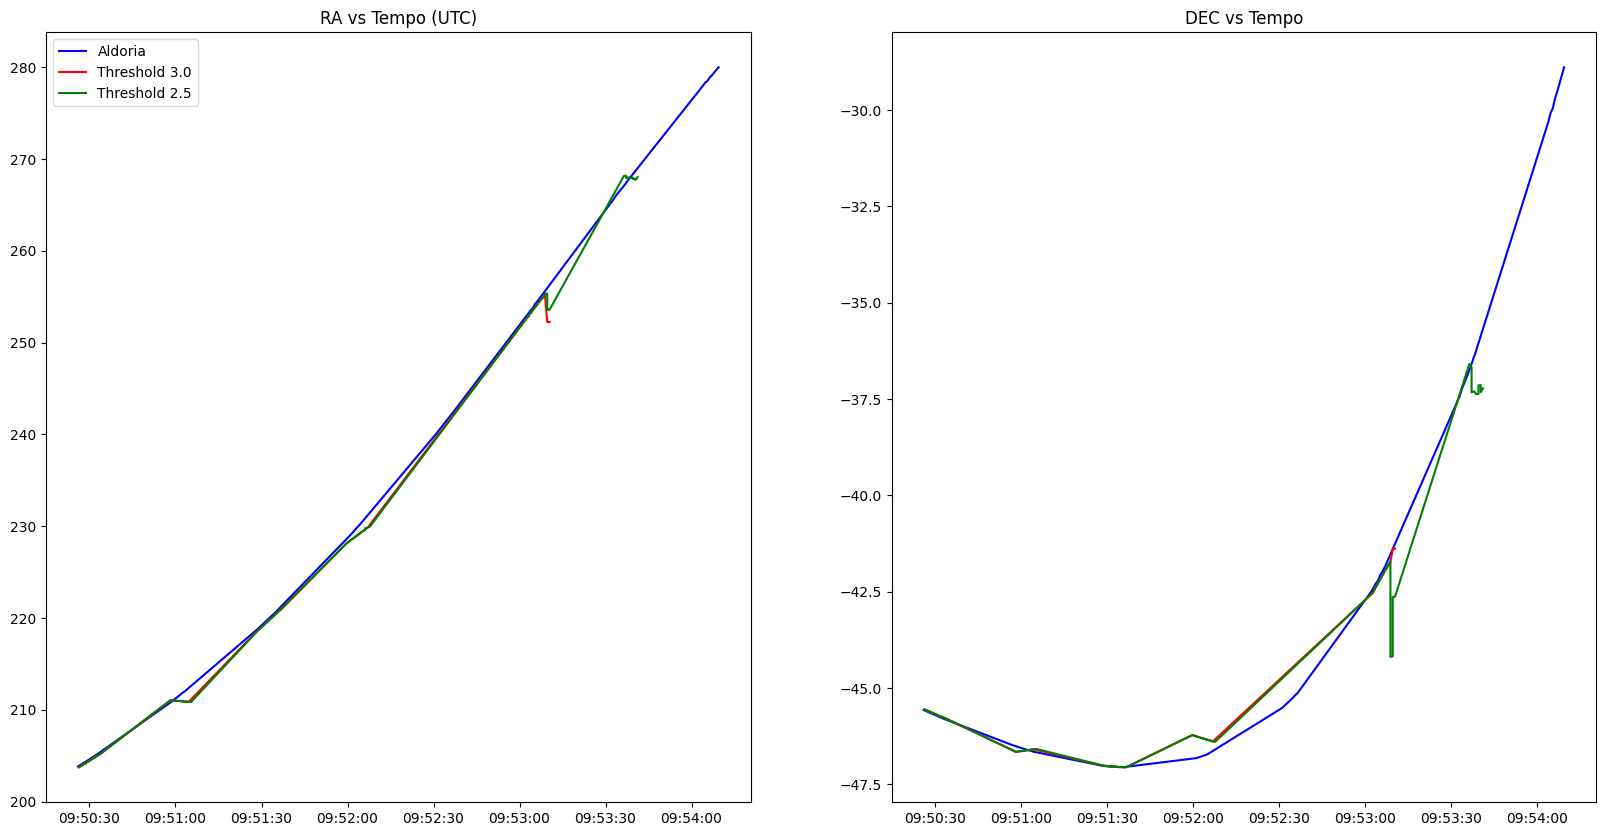

In [357]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['RA[deg]'],color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['RA[deg]'],color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['DEC[deg]'],color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

### Análise de Outliers

Para analisarmos os outliers, devemos interpolar polinomialmente os dados:

In [358]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30,tdm_30)

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25,tdm_25)

In [359]:
# Filtragem a partir do RA
std_ra = tdm_30_fit.describe().loc['std','Desvio RA (%)']
mean_ra = tdm_30_fit.describe().loc['mean','Desvio RA (%)']
third_quarter_ra = tdm_30_fit.describe().loc['75%','Desvio RA (%)']
std_dec = tdm_30_fit.describe().loc['std','Desvio DEC (%)']
mean_dec = tdm_30_fit.describe().loc['mean','Desvio DEC (%)']
third_quarter_dec = tdm_30_fit.describe().loc['75%','Desvio DEC (%)']
filter = (abs(tdm_30_fit['Desvio RA (%)'] - mean_ra) < 3.0*std_ra) & (abs(tdm_30_fit['Desvio DEC (%)'] - mean_dec) < 3.0*std_dec)
# filter = (tdm_30_fit['Desvio RA (%)'] < third_quarter_ra) & (tdm_30_fit['Desvio DEC (%)'] < third_quarter_dec)
# filter = (tdm_30_fit['Desvio RA (deg)'] < 0.25) & (tdm_30_fit['Desvio DEC (deg)'] < 0.25)
time_filtered = tdm_30_fit[filter]['Tempo[s]']
tdm_30_filtered = tdm_30.loc[tdm_30['Tempo[s]'].isin(time_filtered)]

In [360]:
# Filtragem a partir do RA
std_ra = tdm_25_fit.describe().loc['std','Desvio RA (%)']
mean_ra = tdm_25_fit.describe().loc['mean','Desvio RA (%)']
third_quarter_ra = tdm_25_fit.describe().loc['75%','Desvio RA (%)']
std_dec = tdm_25_fit.describe().loc['std','Desvio DEC (%)']
mean_dec = tdm_25_fit.describe().loc['mean','Desvio DEC (%)']
third_quarter_dec = tdm_25_fit.describe().loc['75%','Desvio DEC (%)']
filter = (abs(tdm_25_fit['Desvio RA (%)'] - mean_ra) < 3.0*std_ra) & (abs(tdm_25_fit['Desvio DEC (%)'] - mean_dec) < 3.0*std_dec)
# filter = (tdm_25_fit['Desvio RA (%)'] < third_quarter_ra) & (tdm_25_fit['Desvio DEC (%)'] < third_quarter_dec)
# filter = (tdm_25_fit['Desvio RA (deg)'] < 0.25) & (tdm_25_fit['Desvio DEC (deg)'] < 0.25)
time_filtered = tdm_25_fit[filter]['Tempo[s]']
tdm_25_filtered = tdm_25.loc[tdm_25['Tempo[s]'].isin(time_filtered)]

### Comparação com os dados da Aldoria

In [361]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30_filtered,tdm_aldoria)

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25_filtered,tdm_aldoria)

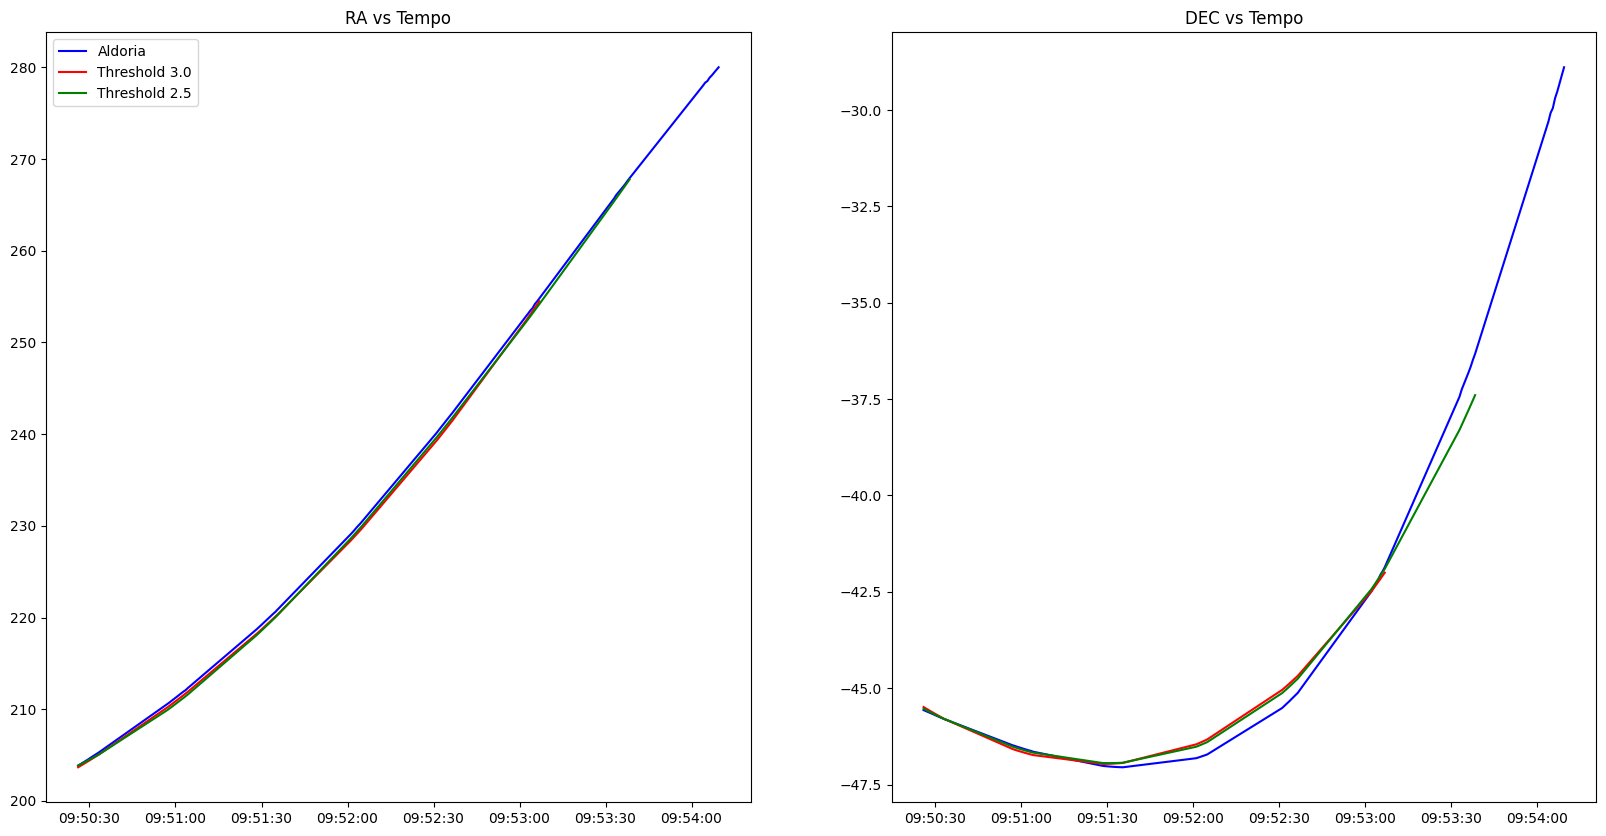

In [362]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['RA[deg]'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['RA[deg]'],color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['DEC[deg]'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

In [363]:
import numpy as np

#Desvios para RA
median_ra = np.median(tdm_30_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_30_fit['Desvio RA (%)'])
std_ra = np.std(tdm_30_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_30_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_30_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_30_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_30_fit['Desvio RA (%)'].max(),
    'Máximo erro RA (deg)': tdm_30_fit['Desvio RA (deg)'].max(),
    'Máximo erro DEC (%)': tdm_30_fit['Desvio DEC (%)'].max(),
    'Máximo erro DEC (deg)': tdm_30_fit['Desvio DEC (deg)'].max()
}

stats = pd.DataFrame(index = ['Threshold 3.0'] ,data = dados_stats)

#Desvios para RA
median_ra = np.median(tdm_25_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_25_fit['Desvio RA (%)'])
std_ra = np.std(tdm_25_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_25_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_25_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_25_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_25_fit['Desvio RA (%)'].max(),
    'Máximo erro RA (deg)': tdm_25_fit['Desvio RA (deg)'].max(),
    'Máximo erro DEC (%)': tdm_25_fit['Desvio DEC (%)'].max(),
    'Máximo erro DEC (deg)': tdm_25_fit['Desvio DEC (deg)'].max()
}

stats = stats._append(dados_stats,ignore_index=True)
stats.index = ['Threshold 3.0', 'Threshold 2.5']

stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro RA (deg),Máximo erro DEC (%),Máximo erro DEC (deg)
Threshold 3.0,0.212879,0.361333,0.186245,0.208088,0.086401,0.344647,0.357830,0.863764,1.032807,0.470084
Threshold 2.5,0.206451,0.561895,0.218615,0.162979,0.096657,0.827707,0.331948,0.704724,2.951178,1.071975


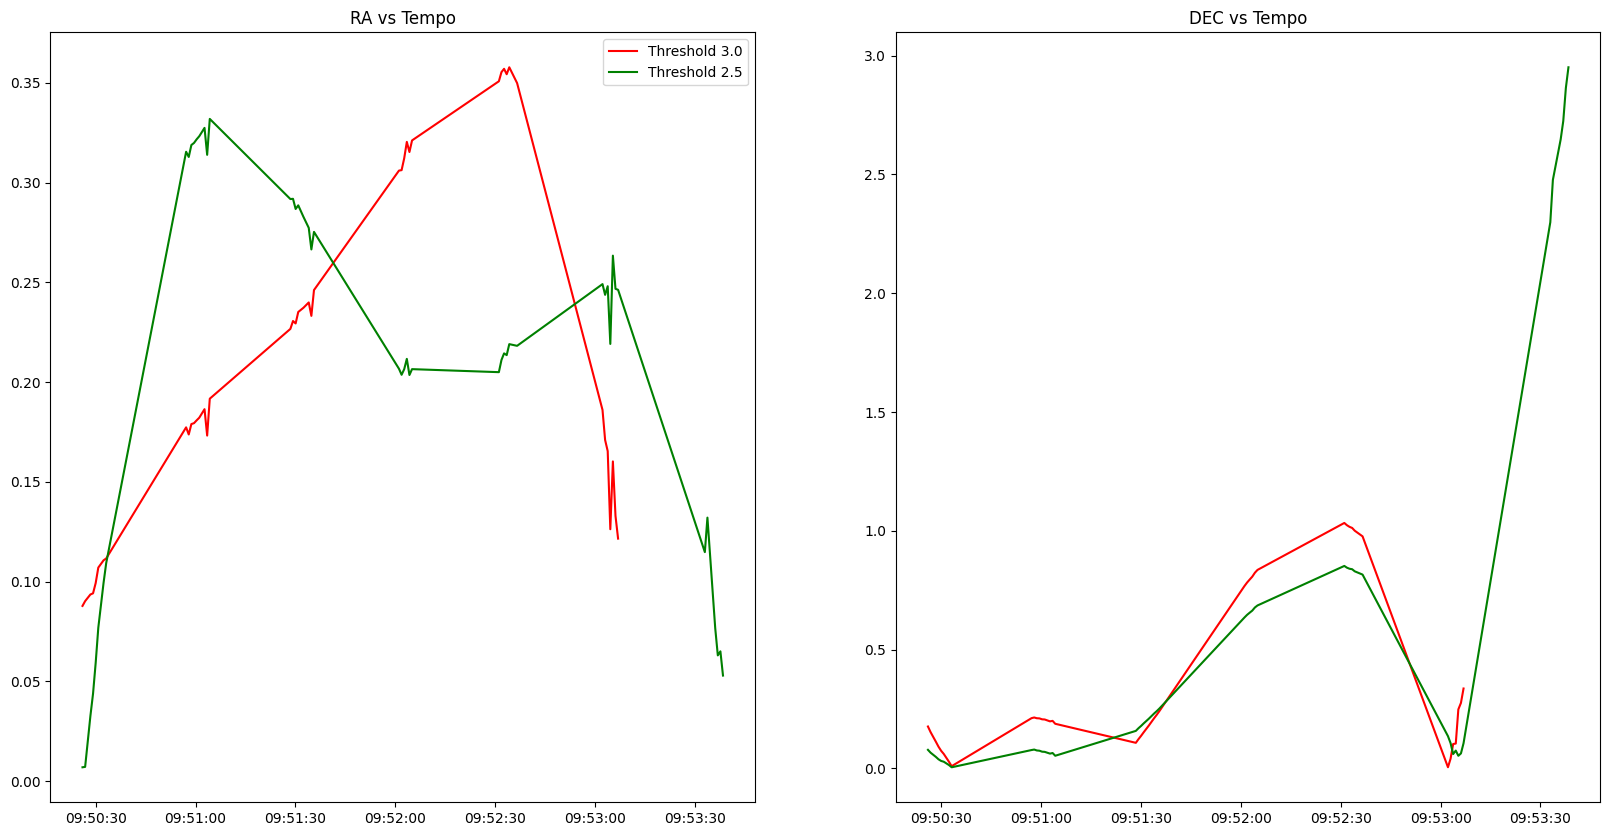

In [364]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio RA (%)'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio RA (%)'],color='green')
plt.legend(['Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio DEC (%)'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio DEC (%)'],color='green')
plt.title('DEC vs Tempo')
plt.show()

## Análise de FOV Parameter

Nessa análise, alterou-se o parâmetro multiplicador do FOV para 1.5 e a área de procura de estrelas no Gaia passou a ser retangular.

In [365]:
tdm_aldoria = get_track_data('Dados\\TDM_7646.txt')
tdm_30 = get_track_data('Dados\\TDM\\Field-Of-View\\TDM-Saipher-15.txt')
tdm_25 = get_track_data('Dados\\TDM\\Field-Of-View\\TDM-Saipher-15-25.txt')


C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\2665463845.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\2665463845.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30['Tempo (UTC)'],tdm_30['RA[deg]'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\2665463845.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25['Tempo (UTC)'],tdm_25['RA[deg]'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\2665463845.py:12: User

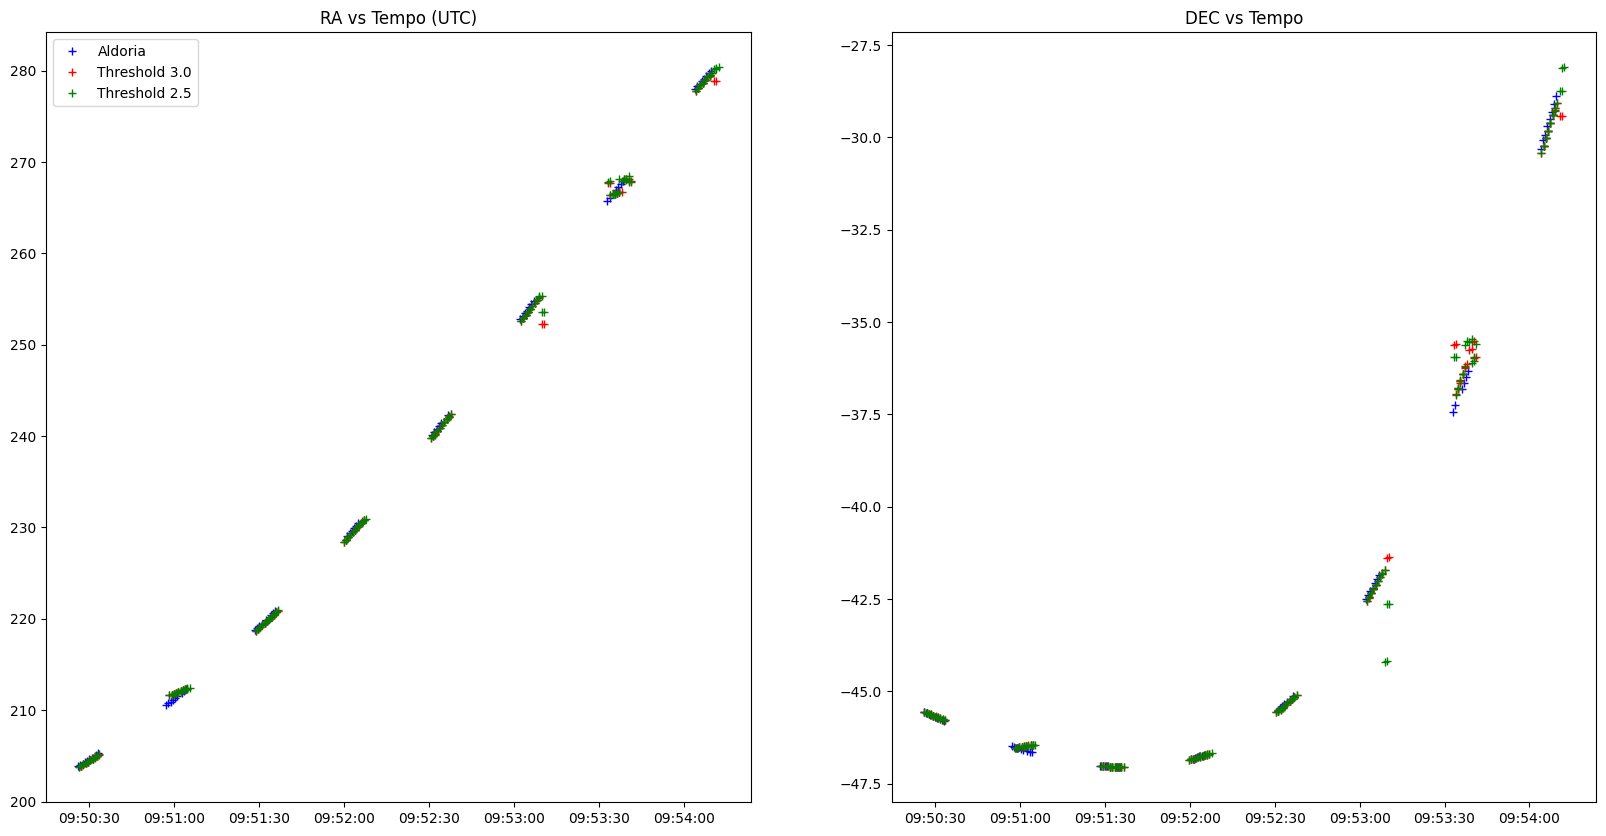

In [366]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['RA[deg]'],'r+',color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['RA[deg]'],'r+',color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],'r+',color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['DEC[deg]'],'r+',color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['DEC[deg]'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

### Tratamento de Outliers

In [367]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30,tdm_30)
tdm_30_filtered = tdm_30

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25,tdm_25)
tdm_25_filtered = tdm_25

In [368]:
# Filtragem a partir do RA
std_ra = tdm_30_fit.describe().loc['std','Desvio RA (%)']
mean_ra = tdm_30_fit.describe().loc['mean','Desvio RA (%)']
third_quarter_ra = tdm_30_fit.describe().loc['75%','Desvio RA (%)']
std_dec = tdm_30_fit.describe().loc['std','Desvio DEC (%)']
mean_dec = tdm_30_fit.describe().loc['mean','Desvio DEC (%)']
third_quarter_dec = tdm_30_fit.describe().loc['75%','Desvio DEC (%)']
# filter = (abs(tdm_30_fit['Desvio RA (%)'] - mean_ra) < 0.5*std_ra) & (abs(tdm_30_fit['Desvio DEC (%)'] - mean_dec) < 0.5*std_dec)
filter = (tdm_30_fit['Desvio RA (%)'] < third_quarter_ra) & (tdm_30_fit['Desvio DEC (%)'] < third_quarter_dec)
# filter = (tdm_30_fit['Desvio RA (deg)'] < 0.25) & (tdm_30_fit['Desvio DEC (deg)'] < 0.25)
time_filtered = tdm_30_fit[filter]['Tempo[s]']
tdm_30_filtered = tdm_30.loc[tdm_30['Tempo[s]'].isin(time_filtered)]

In [369]:
# Filtragem a partir do RA
std_ra = tdm_25_fit.describe().loc['std','Desvio RA (%)']
mean_ra = tdm_25_fit.describe().loc['mean','Desvio RA (%)']
third_quarter_ra = tdm_25_fit.describe().loc['75%','Desvio RA (%)']
std_dec = tdm_25_fit.describe().loc['std','Desvio DEC (%)']
mean_dec = tdm_25_fit.describe().loc['mean','Desvio DEC (%)']
third_quarter_dec = tdm_25_fit.describe().loc['75%','Desvio DEC (%)']
# filter = (abs(tdm_25_fit['Desvio RA (%)'] - mean_ra) < 0.5*std_ra) & (abs(tdm_25_fit['Desvio DEC (%)'] - mean_dec) < 0.5*std_dec)
filter = (tdm_25_fit['Desvio RA (%)'] < third_quarter_ra) & (tdm_25_fit['Desvio DEC (%)'] < third_quarter_dec)
# filter = (tdm_25_fit['Desvio RA (deg)'] < 0.25) & (tdm_25_fit['Desvio DEC (deg)'] < 0.25)
time_filtered = tdm_25_fit[filter]['Tempo[s]']
tdm_25_filtered = tdm_25.loc[tdm_25['Tempo[s]'].isin(time_filtered)]

C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\3058185789.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\3058185789.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_filtered['Tempo (UTC)'],tdm_30_filtered['RA[deg]'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\3058185789.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25_filtered['Tempo (UTC)'],tdm_25_filtered['RA[deg]'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ip

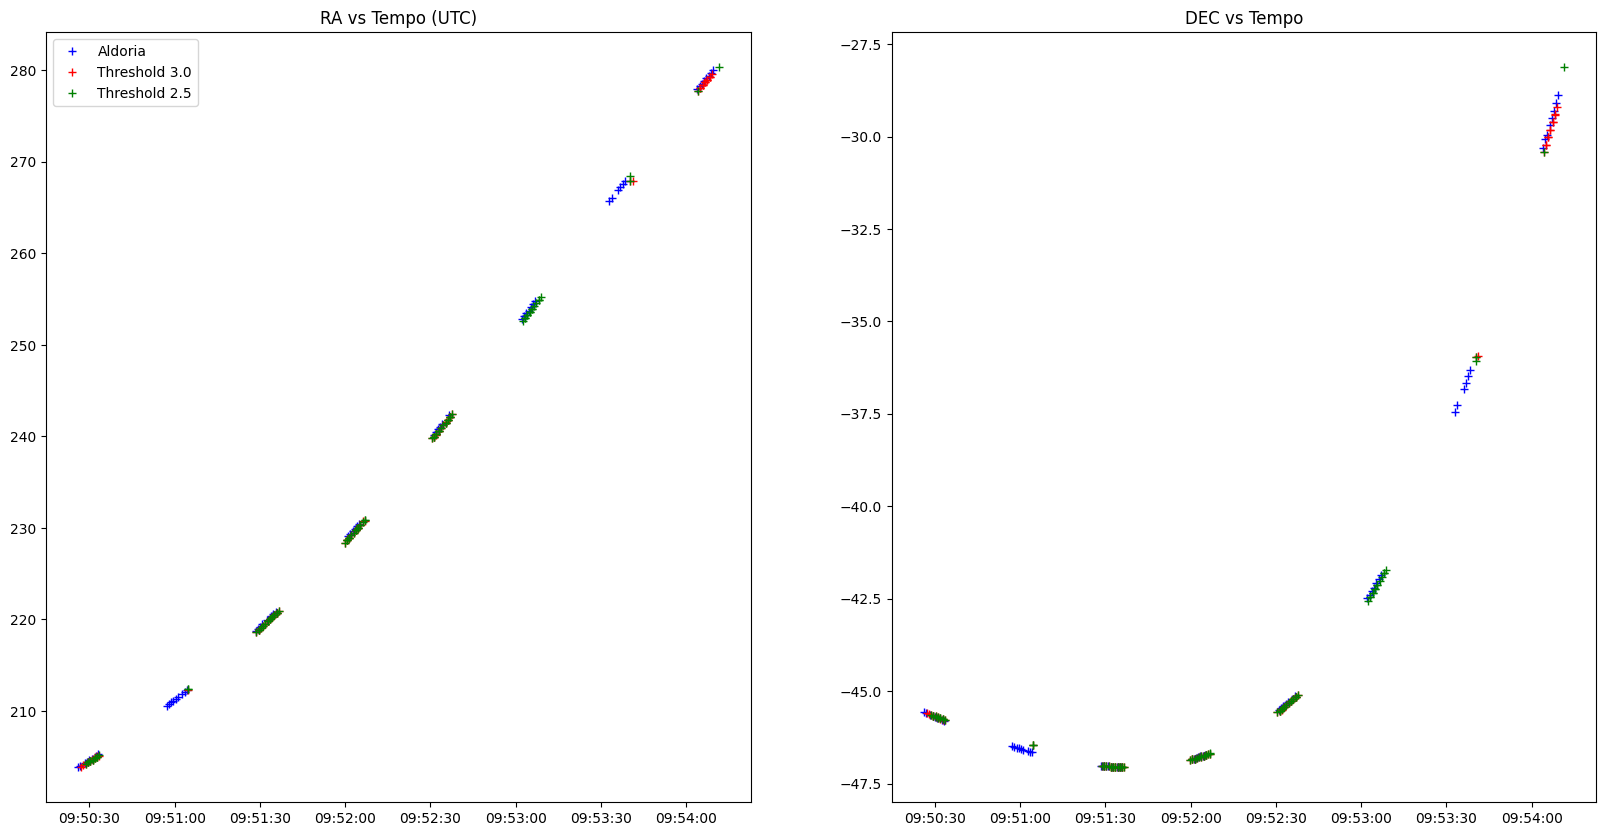

In [370]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
plt.plot(tdm_30_filtered['Tempo (UTC)'],tdm_30_filtered['RA[deg]'],'r+',color='red')
plt.plot(tdm_25_filtered['Tempo (UTC)'],tdm_25_filtered['RA[deg]'],'r+',color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],'r+',color='blue')
plt.plot(tdm_30_filtered['Tempo (UTC)'],tdm_30_filtered['DEC[deg]'],'r+',color='red')
plt.plot(tdm_25_filtered['Tempo (UTC)'],tdm_25_filtered['DEC[deg]'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

In [371]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30_filtered,tdm_aldoria)

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25_filtered,tdm_aldoria)

C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\3207789637.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['RA[deg]'],'r+',color='blue')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\3207789637.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['RA[deg]'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\3207789637.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['RA[deg]'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ipyker

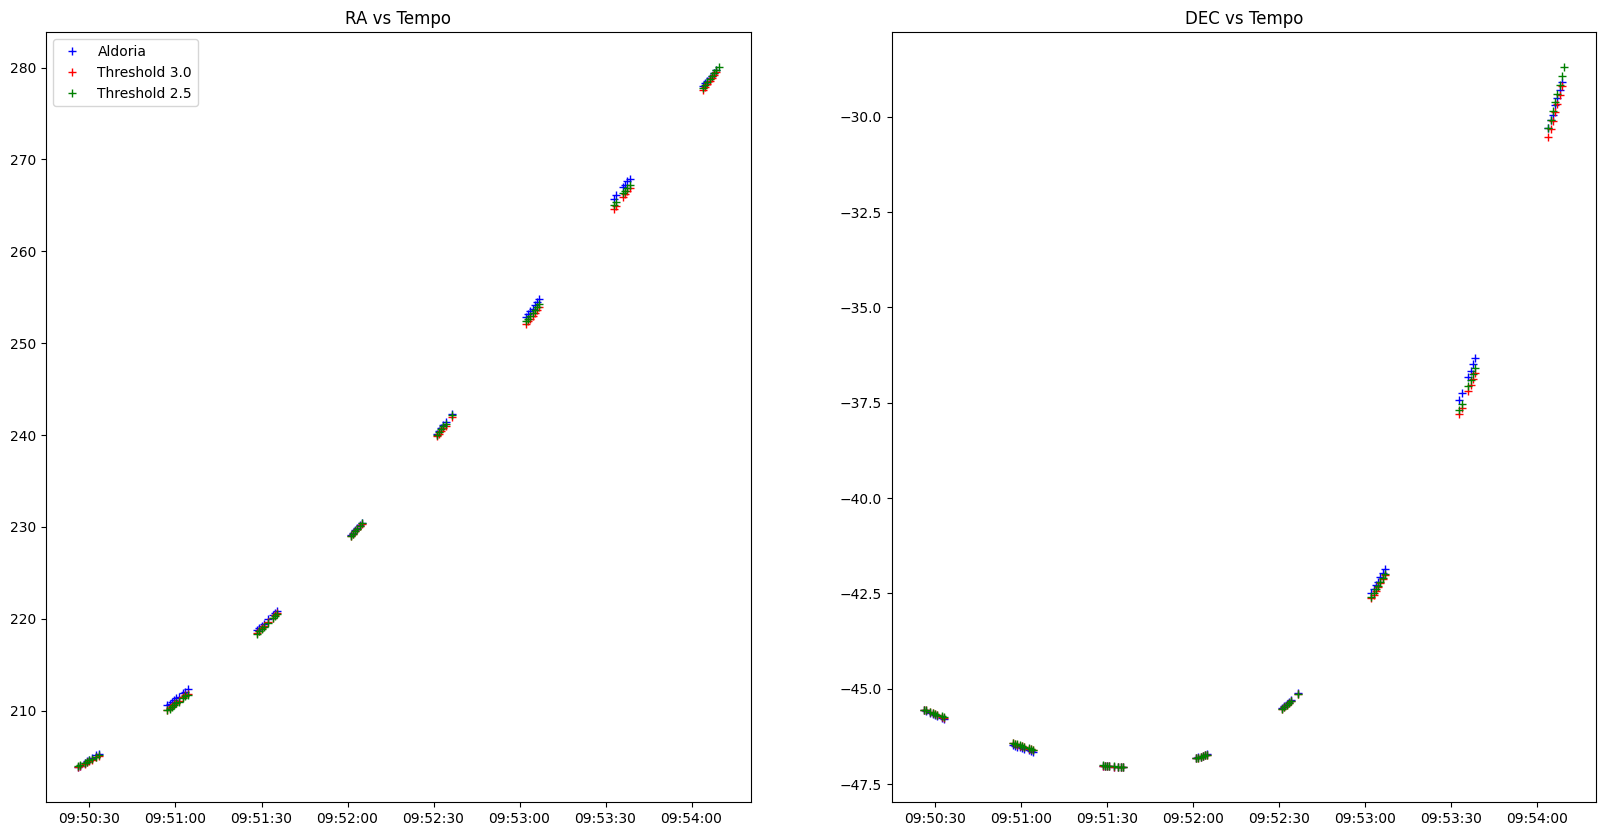

In [372]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
t_12_max = (tdm_30_fit['Tempo[s]']).max()
filter = (tdm_aldoria['Tempo[s]'] <= t_12_max)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['RA[deg]'],'r+',color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['RA[deg]'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['RA[deg]'],'r+',color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['DEC[deg]'],'r+',color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['DEC[deg]'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['DEC[deg]'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

In [373]:
import numpy as np

#Desvios para RA
median_ra = np.median(tdm_30_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_30_fit['Desvio RA (%)'])
std_ra = np.std(tdm_30_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_30_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_30_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_30_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_30_fit['Desvio RA (%)'].max(),
    'Máximo erro RA (deg)': tdm_30_fit['Desvio RA (deg)'].max(),
    'Máximo erro DEC (%)': tdm_30_fit['Desvio DEC (%)'].max(),
    'Máximo erro DEC (deg)': tdm_30_fit['Desvio DEC (deg)'].max()
}

stats = pd.DataFrame(index = ['Threshold 3.0'] ,data = dados_stats)

#Desvios para RA
median_ra = np.median(tdm_25_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_25_fit['Desvio RA (%)'])
std_ra = np.std(tdm_25_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_25_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_25_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_25_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_25_fit['Desvio RA (%)'].max(),
    'Máximo erro RA (deg)': tdm_25_fit['Desvio RA (deg)'].max(),
    'Máximo erro DEC (%)': tdm_25_fit['Desvio DEC (%)'].max(),
    'Máximo erro DEC (deg)': tdm_25_fit['Desvio DEC (deg)'].max()
}

stats = stats._append(dados_stats,ignore_index=True)
stats.index = ['Threshold 3.0', 'Threshold 2.5']

stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro RA (deg),Máximo erro DEC (%),Máximo erro DEC (deg)
Threshold 3.0,0.171479,0.258895,0.132754,0.085168,0.111160,0.331419,0.412099,1.096478,1.073162,0.39976
Threshold 2.5,0.130770,0.186383,0.139747,0.101526,0.094589,0.222662,0.281674,0.749456,0.769168,0.28652


C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\1492955811.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio RA (deg)'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\1492955811.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio RA (deg)'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_32796\1492955811.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio DEC (deg)'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\

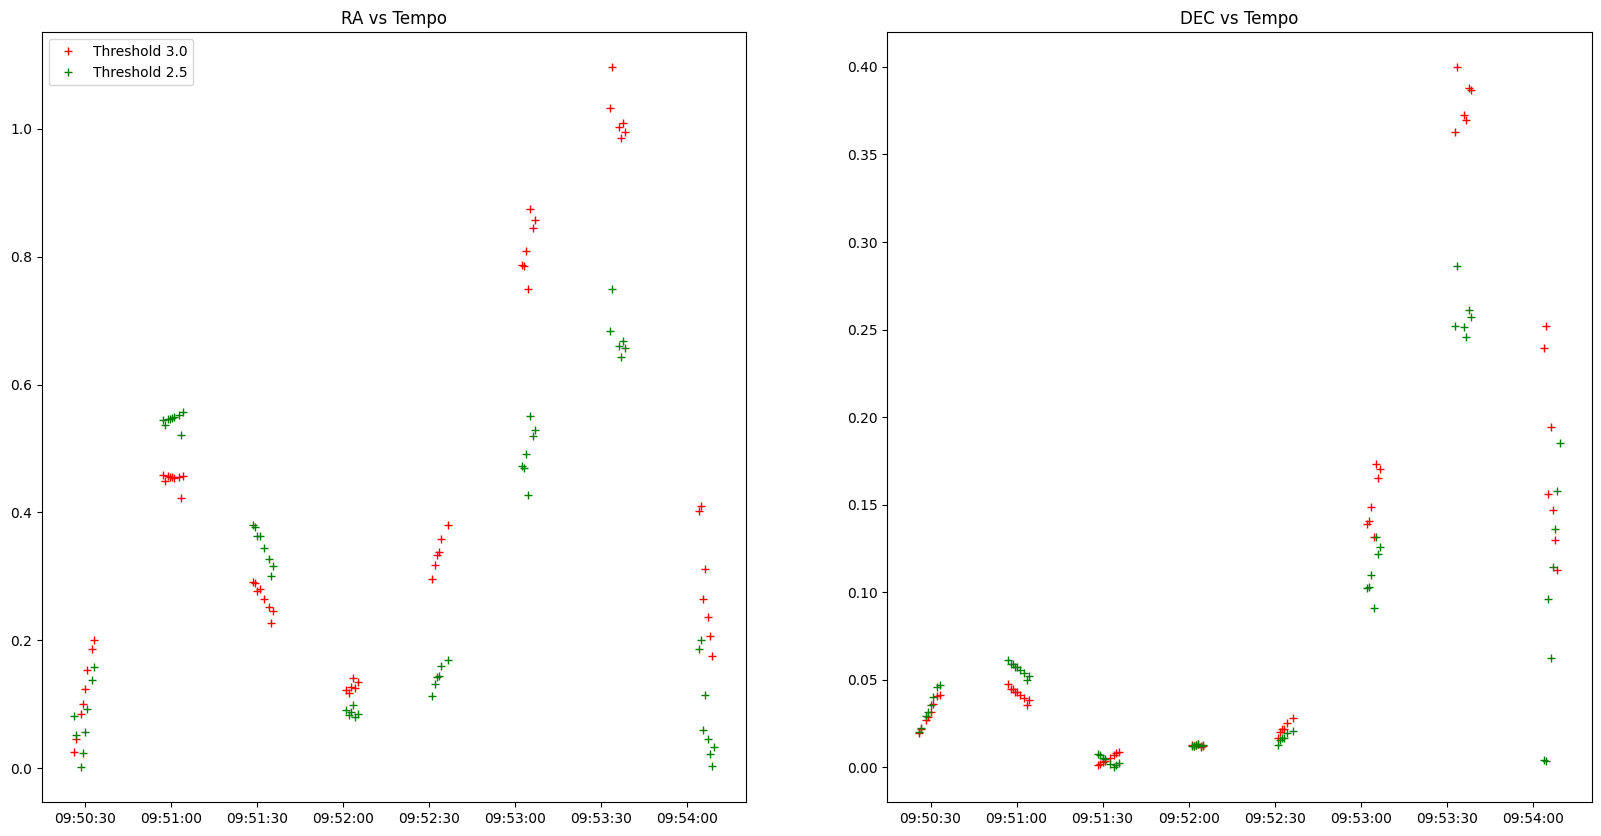

In [374]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio RA (deg)'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio RA (deg)'],'r+',color='green')
plt.legend(['Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio DEC (deg)'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio DEC (deg)'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

In [375]:
tdm_25_fit.describe()

,Tempo (UTC),Tempo[s],RA[deg],DEC[deg],Desvio RA (%),Desvio DEC (%),Desvio RA (deg),Desvio DEC (deg)
count,58,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,2023-04-25 09:52:13.393688832,1.682427e+09,236.452986,-42.544842,0.130770,0.186383,0.307770,0.070451
min,2023-04-25 09:50:26.038453,1.682427e+09,203.928703,-47.054948,0.000605,0.000171,0.001236,0.000080
25%,2023-04-25 09:51:02.886077184,1.682427e+09,211.399979,-46.591665,0.039984,0.027659,0.091210,0.012804
50%,2023-04-25 09:52:03.842255104,1.682427e+09,229.949784,-45.593684,0.139747,0.101526,0.308460,0.046485
75%,2023-04-25 09:53:06.706269696,1.682427e+09,254.183082,-42.012225,0.234767,0.255794,0.534753,0.102783
max,2023-04-25 09:54:09.439753,1.682427e+09,280.029642,-28.703098,0.281674,0.769168,0.749456,0.286520
std,NaN,7.408365e+01,26.001835,6.037777,0.095415,0.224607,0.227754,0.078435


In [376]:
tdm_saipher_bruto = tdm_30_fit
tdm_saipher = tdm_saipher_bruto

n_saipher = len(tdm_saipher['Tempo[s]'])                                # Quantidade de observações realizadas

initial_saipher = 0
middle_saipher = int(n_saipher/2)
end_saipher = n_saipher - 1

# t_saipher = [tdm_saipher['Tempo[s]'][initial_saipher],tdm_saipher['Tempo[s]'][middle_saipher],tdm_saipher['Tempo[s]'][end_saipher]] # Horário das observações utilizadas na IOD [s]


In [377]:
tdm_saipher['Tempo[s]'].iloc[initial_saipher]

1682427026.038453

In [383]:
from src.orbit.orbit_determination import *

# Dados do Observatório da Aldoria:
latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799                                         # [deg]
altitude = 2180e-3                                              # [km]
latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Observações:
tdm_aldoria_bruto = get_track_data('Dados\\TDM_7646.txt')
tdm_saipher_bruto = tdm_25_filtered

# Ajuste dos dados
# tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max())
tdm_aldoria = tdm_aldoria_bruto[tdm_aldoria_bruto['Tempo[s]'] <= max(tdm_saipher_bruto['Tempo[s]'])]
tdm_saipher = tdm_saipher_bruto

n_aldoria = len(tdm_aldoria['Tempo[s]'])                                # Quantidade de observações realizadas
n_saipher = len(tdm_saipher['Tempo[s]'])                                # Quantidade de observações realizadas

# Posições Analisadas:
initial_aldoria = 0
middle_aldoria = int(n_aldoria/2)
end_aldoria = n_aldoria - 1
initial_saipher = 0
middle_saipher = int(n_saipher/2)
end_saipher = n_saipher - 1

# Parâmetros únicos de cada "TDM":
t_aldoria = [tdm_aldoria['Tempo[s]'][initial_aldoria],tdm_aldoria['Tempo[s]'][middle_aldoria],tdm_aldoria['Tempo[s]'][end_aldoria]] # Horário das observações utilizadas na IOD [s]
t_saipher = [tdm_saipher['Tempo[s]'].iloc[initial_saipher],tdm_saipher['Tempo[s]'].iloc[middle_saipher],tdm_saipher['Tempo[s]'].iloc[end_saipher]] # Horário das observações utilizadas na IOD [s]
local_sidereal_time_aldoria = [
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][initial_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][middle_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][end_aldoria]),
    ]
local_sidereal_time_saipher = [
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[initial_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[middle_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[end_saipher]),
    ]
RAs_aldoria = [tdm_aldoria['RA[deg]'][initial_aldoria],tdm_aldoria['RA[deg]'][middle_aldoria],tdm_aldoria['RA[deg]'][end_aldoria]]
DECs_aldoria = [tdm_aldoria['DEC[deg]'][initial_aldoria],tdm_aldoria['DEC[deg]'][middle_aldoria],tdm_aldoria['DEC[deg]'][end_aldoria]]
RAs_saipher = [tdm_saipher['RA[deg]'].iloc[initial_saipher],tdm_saipher['RA[deg]'].iloc[middle_saipher],tdm_saipher['RA[deg]'].iloc[end_saipher]]
# RAs_saipher = [
#     0.5*(tdm_saipher['RA[deg]'][initial_saipher] + RAs_aldoria[0]),
#     0.5*(tdm_saipher['RA[deg]'][middle_saipher] + RAs_aldoria[1]),
#     (1/4)*(tdm_saipher['RA[deg]'][end_saipher] + 3*RAs_aldoria[2])
# ]
DECs_saipher = [tdm_saipher['DEC[deg]'].iloc[initial_saipher],tdm_saipher['DEC[deg]'].iloc[middle_saipher],tdm_saipher['DEC[deg]'].iloc[end_saipher]]

# Estimativa inicial do vetor de estado do objeto (r2,v2):
r2_aldoria,v2_aldoria = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_aldoria,
    RAs = RAs_aldoria,
    DECs = DECs_aldoria,
    times = t_aldoria)

r2_saipher,v2_saipher = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_saipher,
    RAs = RAs_saipher,
    DECs = DECs_saipher,
    times = t_saipher)

# Obtenção dos elementos orbitais:
h_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria,theta_aldoria = classic_orbital_elements_from_rv(r2_aldoria,v2_aldoria)
h_saipher,i_saipher,ra_saipher,e_saipher,w_saipher,theta_saipher = classic_orbital_elements_from_rv(r2_saipher,v2_saipher)

# Obtenção do semi-eixo maior:
a_aldoria = semimajor_axis_from_he(h_aldoria,e_aldoria)
a_saipher = semimajor_axis_from_he(h_saipher,e_saipher)

# Dados do TLE
# 1 07646U 75010A   23115.56559076 -.00000125  00000-0  12485-4 0  9994
# 2 07646  49.8253 318.3095 0205748 228.5962 129.7086 13.82317979435651
e_tle = 0.02057480
i_tle = 49.8253
ra_tle = 318.3095
w_tle = 228.5962
a_tle = 7333.814
m_tle = 129.7086


# Resultados:
print('Parâmetros de Entrada:')
print('--------------------------------- Aldoria ----------------------------------')
print(f'RA = {np.round(RAs_aldoria,3)}')
print(f'DEC = {np.round(DECs_aldoria,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_aldoria,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_aldoria[0]-t_aldoria[0],t_aldoria[1]-t_aldoria[0],t_aldoria[2]-t_aldoria[0]],2)}')
print()
print('--------------------------------- Saipher ----------------------------------')
print(f'RA = {np.round(RAs_saipher,3)}')
print(f'DEC = {np.round(DECs_saipher,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_saipher,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_saipher[0]-t_saipher[0],t_saipher[1]-t_saipher[0],t_saipher[2]-t_saipher[0]],2)}')
print()

results = {
    'Aldoria':[a_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria],
    'Saipher':[a_saipher,i_saipher,ra_saipher,e_saipher,w_saipher],
    'TLE':[a_tle,i_tle,ra_tle,e_tle,w_tle]
}

orbital_parameters_df = pd.DataFrame(
    index = ['Semi-eixo maior [km]','Inclinação [°]','Ascensão reta do nó de ascensão [°]','Ecentricidade [-]','Argumento do Pergieu [°]'],
    data = results)

print('Vetores de Estado:')
print(f'v2_aldoria = {round(v2_aldoria.x,4)}I + ({round(v2_aldoria.y,4)})J + ({round(v2_aldoria.z,4)})K')
print(f'v2_saipher = {round(v2_saipher.x,4)}I + ({round(v2_saipher.y,4)})J + ({round(v2_saipher.z,4)})K     (ex = {round(abs(100*(v2_saipher.x-v2_aldoria.x)/v2_aldoria.x),4)}% ey = {round(abs(100*(v2_saipher.y-v2_aldoria.y)/v2_aldoria.y),4)}% ez = {round(abs(100*(v2_saipher.z-v2_aldoria.z)/v2_aldoria.z),4)}%)')
print(f'r2_aldoria = {round(r2_aldoria.x,4)}I + ({round(r2_aldoria.y,4)})J + ({round(r2_aldoria.z,4)})K')
print(f'r2_saipher = {round(r2_saipher.x,4)}I + ({round(r2_saipher.y,4)})J + ({round(r2_saipher.z,4)})K     (ex = {round(abs(100*(r2_saipher.x-r2_aldoria.x)/r2_aldoria.x),4)}% ey = {round(abs(100*(r2_saipher.y-r2_aldoria.y)/r2_aldoria.y),4)}% ez = {round(abs(100*(r2_saipher.z-r2_aldoria.z)/r2_aldoria.z),4)}%)')
print('\nParâmetros Orbitais:')
orbital_parameters_df

Parâmetros de Entrada:
--------------------------------- Aldoria ----------------------------------
RA = [203.848 230.168 279.996]
DEC = [-45.569 -46.74  -28.888]
Tempo Sideral = [289.914 290.324 290.846]
Intervalos de Tempo [s] = [  0.   98.2 223.4]

--------------------------------- Saipher ----------------------------------
RA = [204.218 230.021 280.344]
DEC = [-45.631 -46.745 -28.128]
Tempo Sideral = [289.923 290.324 290.854]
Intervalos de Tempo [s] = [  0.    95.85 222.69]

Vetores de Estado:
v2_aldoria = 6.2854I + (-1.3977)J + (3.6609)K
v2_saipher = 4.6583I + (-0.8642)J + (2.7515)K     (ex = 25.8866% ey = 38.167% ez = 24.84%)
r2_aldoria = 1334.598I + (-5861.4097)J + (-4166.6119)K
r2_saipher = 1491.8033I + (-5670.3151)J + (-3903.8002)K     (ex = 11.7792% ey = 3.2602% ez = 6.3076%)

Parâmetros Orbitais:


,Aldoria,Saipher,TLE
Semi-eixo maior [km],7363.593056,4793.346622,7333.814000
Inclinação [°],49.774642,49.360941,49.825300
Ascensão reta do nó de ascensão [°],318.718731,319.591494,318.309500
Ecentricidade [-],0.025400,0.470216,0.020575
Argumento do Pergieu [°],235.640729,134.940704,228.596200


In [384]:
diff_ra = []
diff_dec = []
desvio_ra = []
desvio_dec = []
for i in range(0,3):
    diff_ra_aux = RAs_aldoria[i]-RAs_saipher[i]
    diff_dec_aux = DECs_aldoria[i]-DECs_saipher[i]
    diff_ra.append(diff_ra_aux)
    diff_dec.append(diff_dec_aux)
    desvio_ra.append(abs(100*(diff_ra_aux)/RAs_aldoria[i]))
    desvio_dec.append(abs(100*(diff_dec_aux)/DECs_aldoria[i]))

print(f'diff_RA =  {np.round(diff_ra,3)} [°]')
print(f'diff_DEC = {np.round(diff_dec,3)} [°]')
print(f'desvio_RA =  {np.round(desvio_ra,3)} [%]')
print(f'desvio_DEC = {np.round(desvio_dec,3)} [%]')

diff_RA =  [-0.371  0.147 -0.348] [°]
diff_DEC = [ 0.062  0.005 -0.76 ] [°]
desvio_RA =  [0.182 0.064 0.124] [%]
desvio_DEC = [0.136 0.012 2.632] [%]


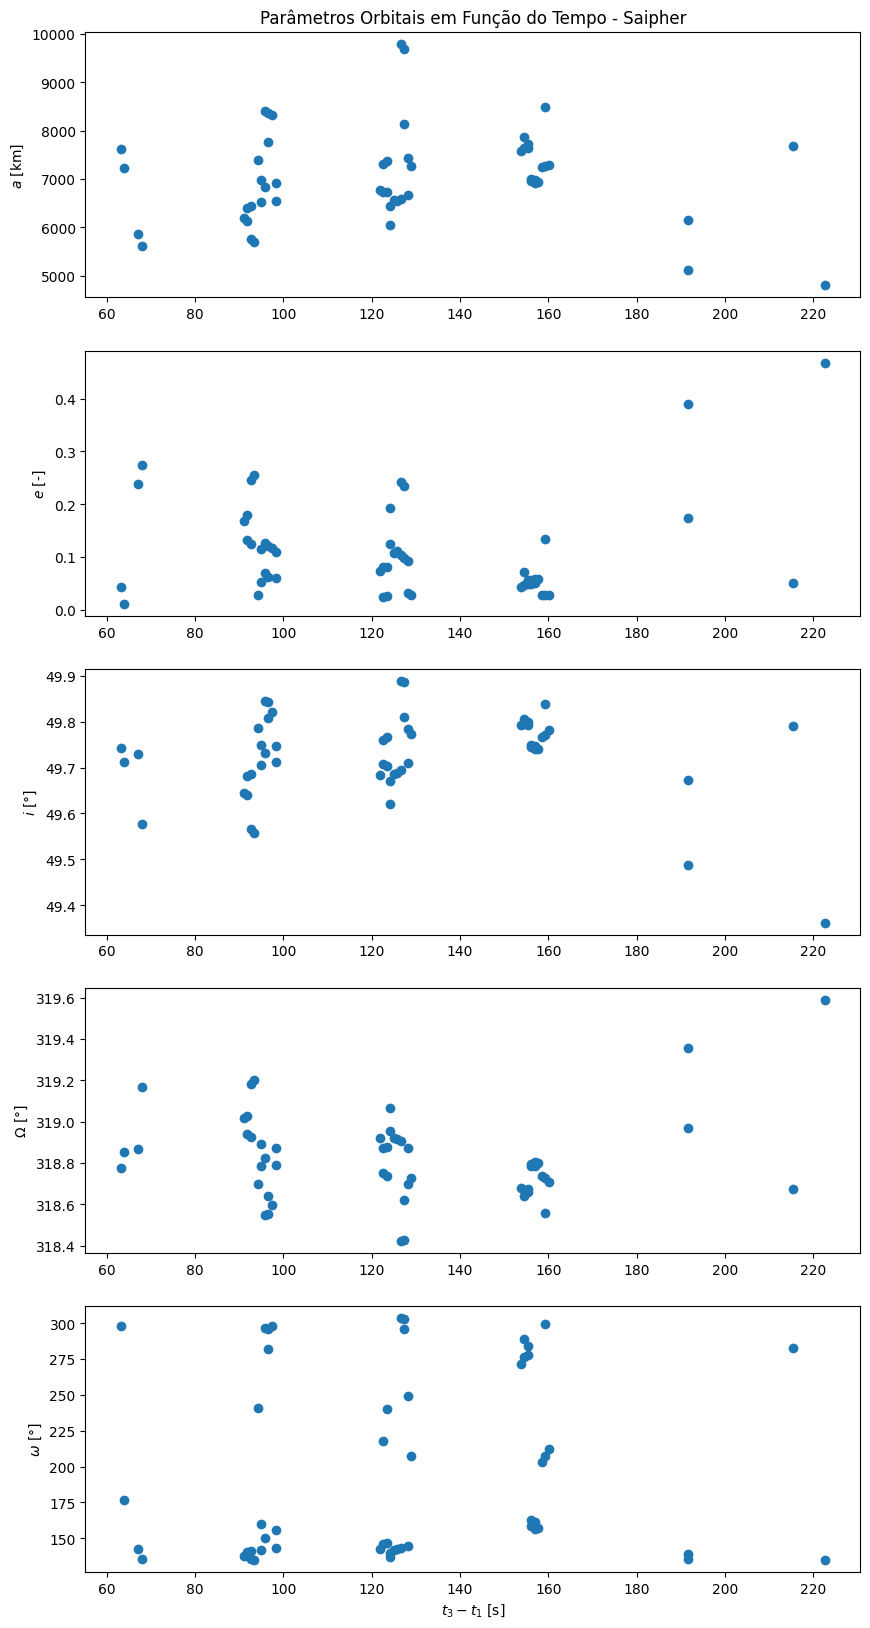

In [400]:
# Parâmetros Orbitais para a Saipher

# Dados do Observatório da Aldoria:
latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799                                         # [deg]
altitude = 2180e-3                                              # [km]
latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Observações:
tdm_saipher_bruto = tdm_25_filtered

# Ajuste dos dados
# tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max()+60)
tdm_saipher = tdm_saipher_bruto

n_saipher = len(tdm_saipher['Tempo[s]'])  # Quantidade de observações realizadas

# Parâmetros:
dt_saipher = []
a_saipher = []
i_saipher = []
omega_saipher = []
w_saipher = []
e_saipher = []

for n in range(2,n_saipher):
    # Posições Analisadas:
    initial_saipher = 0
    middle_saipher = int(n/2)
    end_saipher = n

    # Parâmetros únicos de cada "TDM":
    t_saipher = [tdm_saipher['Tempo[s]'].iloc[initial_saipher],tdm_saipher['Tempo[s]'].iloc[middle_saipher],tdm_saipher['Tempo[s]'].iloc[end_saipher]] # Horário das observações utilizadas na IOD [s]
    local_sidereal_time_saipher = [
        sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[initial_saipher]),
        sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[middle_saipher]),
        sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[end_saipher]),
        ]
    RAs_saipher = [tdm_saipher['RA[deg]'].iloc[initial_saipher],tdm_saipher['RA[deg]'].iloc[middle_saipher],tdm_saipher['RA[deg]'].iloc[end_saipher]]
    DECs_saipher = [tdm_saipher['DEC[deg]'].iloc[initial_saipher],tdm_saipher['DEC[deg]'].iloc[middle_saipher],tdm_saipher['DEC[deg]'].iloc[end_saipher]]

    # Estimativa inicial do vetor de estado do objeto (r2,v2):
    r2,v2 = r2v2_from_angles_only_gauss(
        latitude_geodetic = latitude_geodetic,
        altitude = altitude,
        local_sidereal_times = local_sidereal_time_saipher,
        RAs = RAs_saipher,
        DECs = DECs_saipher,
        times = t_saipher)
    
    # Parâmetros Orbitais:
    h,i,omega,e,w,theta = classic_orbital_elements_from_rv(r2,v2)
    a = semimajor_axis_from_he(h,e)

    # Adição dos Dados Obtidos:
    dt_saipher.append(t_saipher[2] - t_saipher[0])
    a_saipher.append(a)
    i_saipher.append(i)
    omega_saipher.append(omega)
    w_saipher.append(w)
    e_saipher.append(e)

# Criação de Data Frame com os Dados:
orbital_param_saipher = pd.DataFrame(data={
    'Delta_t' : dt_saipher,
    'a':a_saipher,
    'i':i_saipher,
    'omega':omega_saipher,
    'w':w_saipher,
    'e':e_saipher,
})

# Filtro de Outliers:
orbital_param_saipher.dropna(inplace=True)
orbital_param_saipher.where((orbital_param_saipher['e'] < 0.5),inplace=True)

# Plot dos Resultados:
plt.figure(figsize=(10,20))
# plt.rcParams['text.usetex'] = True
ax1 = plt.subplot(5,1,1)
ax1.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['a'])
ax1.set_ylabel('$a$ [km]')
ax1.set_title('Parâmetros Orbitais em Função do Tempo - Saipher')
ax2 = plt.subplot(5,1,2)
ax2.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['e'])
ax2.set_ylabel('$e$ [-]')
ax3 = plt.subplot(5,1,3)
ax3.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['i'])
ax3.set_ylabel('$i$ [°]')
ax4 = plt.subplot(5,1,4)
ax4.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['omega'])
ax4.set_ylabel('$\\Omega$ [°]')
ax5 = plt.subplot(5,1,5)
ax5.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['w'])
ax5.set_ylabel('$\\omega$ [°]')
ax5.set_xlabel('$t_3 - t_1$ [s]')
plt.show()

In [402]:
orbital_param_saipher.describe()
df_saipher = orbital_param_saipher[orbital_param_saipher.e < orbital_param_saipher.describe().e['25%']]
df_saipher.describe()

,Delta_t,a,i,omega,w,e
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,130.180812,7375.804884,49.769512,318.729873,231.481720,0.032649
std,34.278840,188.211643,0.023124,0.049738,40.103130,0.011304
min,63.198192,7002.865788,49.711729,318.670471,162.663536,0.010530
25%,122.813380,7265.690112,49.761673,318.696776,207.377502,0.027008
50%,141.380391,7338.001433,49.772472,318.727470,229.010096,0.027982
75%,155.945886,7540.956110,49.785383,318.746678,265.994680,0.043127
max,160.147416,7643.192733,49.795091,318.851672,297.722178,0.048522


Agora, considerando o parâmetro como 2.0